In [1]:
import os
import matplotlib.pyplot as plt
from collections.abc import Callable
import jax.numpy as jnp 
import jax 
import equinox as eqx
import optax
from einops import rearrange
import math


In [2]:
IMAGE_SIZE = 64
BATCH_SIZE = 16
BATCH_COUNT = 32
LATENT_DIMS = 64
T = 1000

# Data Preparation

In [3]:

def load_data(path : str, count : int):
    """Load images from a directory."""
    images = []
    i = 0
    for file in os.listdir(path):
        i += 1
        if i > count:
            break
        if file.endswith(".jpg"):
            images.append(plt.imread(os.path.join(path, file)))

    return images


In [4]:
def make_batches(images : jnp.ndarray, batch_size : int, batch_count : int, size : int):
    """Reshape images into batches."""
    batches = images.reshape((batch_count, batch_size, size, size, 3))
    batches = jnp.transpose(batches, (0, 1, 4, 2, 3))
    batches = batches / 255.0
    return batches


In [5]:
images = load_data("data_processed", 512)
images = jnp.array(images)

batches = make_batches(images, batch_size=BATCH_SIZE, batch_count=BATCH_COUNT, size=IMAGE_SIZE)

print(f"Loaded images result shape: {batches.shape}")
print(f"That is {BATCH_COUNT} batches of {BATCH_SIZE} images of size {IMAGE_SIZE}x{IMAGE_SIZE}x3")
print(f"Image range: {jnp.min(batches)} to {jnp.max(batches)} with mean {jnp.mean(batches)}")

Loaded images result shape: (32, 16, 3, 64, 64)
That is 32 batches of 16 images of size 64x64x3
Image range: 0.0 to 0.9999999403953552 with mean 0.4687947630882263


In [6]:
def generate_alphas(T : int, beta : float = 0.02):
    """Generate alpha and beta schedules for diffusion process."""
    betas = jnp.linspace(beta, 0.2, T)
    alphas = 1 - betas
    alphas_cumprod = jnp.cumprod(alphas)
    return alphas, alphas_cumprod, betas

In [7]:
def batch_noise(
        xs : jnp.ndarray, 
        key : jax.random.PRNGKey,
        alphas_cumprod : jnp.ndarray,
        T : int = 100,
        batch_size : int = BATCH_SIZE
    ):
    """Add noise to a batch of images according to the diffusion schedule."""

    ts = jax.random.randint(key, (batch_size,), minval=1, maxval=T + 1)

    eps = jax.random.normal(key, xs.shape)

    sqrt_alphas_cumprod = jnp.sqrt(alphas_cumprod.at[ts].get())
    sqrt_one_minus_alphas_cumprod = jnp.sqrt(1 - alphas_cumprod.at[ts].get())

    xs_noisy = sqrt_alphas_cumprod[:, None, None, None] * xs + sqrt_one_minus_alphas_cumprod[:, None, None, None] * eps

    return xs_noisy, eps, ts

In [8]:
alphas, alphas_cumprod, betas = generate_alphas(T)
key = jax.random.PRNGKey(0)
batch_noisy, batch_eps, batch_ts = batch_noise(batches[0], key, alphas_cumprod, T, BATCH_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.955557..3.6111305].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.559669..1.2956456].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.5719352..3.604516].


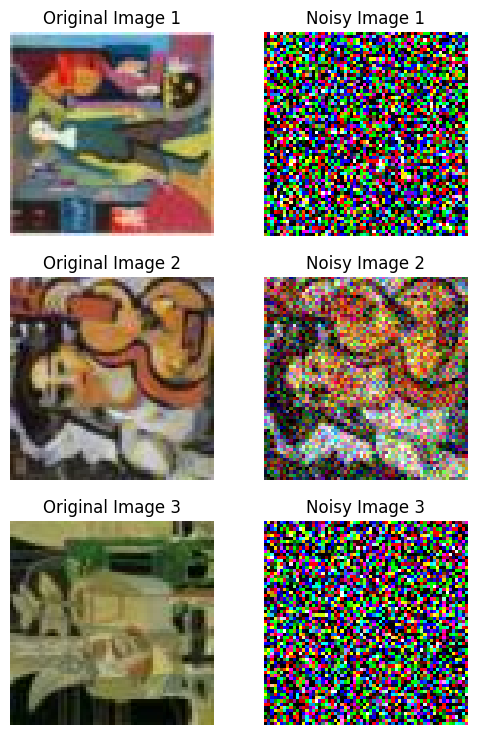

In [9]:
fig, axs = plt.subplots(3, 2, figsize=(6, 9))

for i in range(3):
    axs[i, 1].imshow(jnp.swapaxes(batch_noisy[i], 0, 2))
    axs[i, 1].set_title(f"Noisy Image {i+1}")

    axs[i, 0].imshow(jnp.swapaxes(batches[0, i], 0, 2))
    axs[i, 0].set_title(f"Original Image {i+1}")

    axs[i, 1].axis('off')
    axs[i, 0].axis('off')


plt.show()

# Neural Network

In [ ]:
NUM_EPOCHS = 100
LEARNING_RATE = 1e-4

In [14]:
class SinusoidalPosEmb(eqx.Module):
    emb: jax.Array

    def __init__(self, dim):
        half_dim = dim // 2
        emb = math.log(10000) / (half_dim - 1)
        self.emb = jnp.exp(jnp.arange(half_dim) * -emb)

    def __call__(self, x):
        emb = x * self.emb
        emb = jnp.concatenate((jnp.sin(emb), jnp.cos(emb)), axis=-1)
        return emb


class LinearTimeSelfAttention(eqx.Module):
    group_norm: eqx.nn.GroupNorm
    heads: int
    to_qkv: eqx.nn.Conv2d
    to_out: eqx.nn.Conv2d

    def __init__(
        self,
        dim,
        key,
        heads=4,
        dim_head=32,
    ):
        keys = jax.random.split(key, 2)
        self.group_norm = eqx.nn.GroupNorm(min(dim // 4, 32), dim)
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = eqx.nn.Conv2d(dim, hidden_dim * 3, 1, key=keys[0])
        self.to_out = eqx.nn.Conv2d(hidden_dim, dim, 1, key=keys[1])

    def __call__(self, x):
        c, h, w = x.shape
        x = self.group_norm(x)
        qkv = self.to_qkv(x)
        q, k, v = rearrange(
            qkv, "(qkv heads c) h w -> qkv heads c (h w)", heads=self.heads, qkv=3
        )
        k = jax.nn.softmax(k, axis=-1)
        context = jnp.einsum("hdn,hen->hde", k, v)
        out = jnp.einsum("hde,hdn->hen", context, q)
        out = rearrange(
            out, "heads c (h w) -> (heads c) h w", heads=self.heads, h=h, w=w
        )
        return self.to_out(out)


def upsample_2d(y, factor=2):
    C, H, W = y.shape
    y = jnp.reshape(y, [C, H, 1, W, 1])
    y = jnp.tile(y, [1, 1, factor, 1, factor])
    return jnp.reshape(y, [C, H * factor, W * factor])


def downsample_2d(y, factor=2):
    C, H, W = y.shape
    y = jnp.reshape(y, [C, H // factor, factor, W // factor, factor])
    return jnp.mean(y, axis=[2, 4])


def exact_zip(*args):
    _len = len(args[0])
    for arg in args:
        assert len(arg) == _len
    return zip(*args)


def key_split_allowing_none(key):
    if key is None:
        return key, None
    else:
        return jax.random.split(key)


class Residual(eqx.Module):
    fn: LinearTimeSelfAttention

    def __init__(self, fn):
        self.fn = fn

    def __call__(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x


class ResnetBlock(eqx.Module):
    dim_out: int
    is_biggan: bool
    up: bool
    down: bool
    dropout_rate: float
    time_emb_dim: int
    mlp_layers: list[Callable | eqx.nn.Linear]
    scaling: None | Callable | eqx.nn.ConvTranspose2d | eqx.nn.Conv2d
    block1_groupnorm: eqx.nn.GroupNorm
    block1_conv: eqx.nn.Conv2d
    block2_layers: list[eqx.nn.GroupNorm | eqx.nn.Dropout | eqx.nn.Conv2d | Callable]
    res_conv: eqx.nn.Conv2d
    attn: Residual | None

    def __init__(
        self,
        dim_in,
        dim_out,
        is_biggan,
        up,
        down,
        time_emb_dim,
        dropout_rate,
        is_attn,
        heads,
        dim_head,
        *,
        key,
    ):
        keys = jax.random.split(key, 7)
        self.dim_out = dim_out
        self.is_biggan = is_biggan
        self.up = up
        self.down = down
        self.dropout_rate = dropout_rate
        self.time_emb_dim = time_emb_dim

        self.mlp_layers = [
            jax.nn.silu,
            eqx.nn.Linear(time_emb_dim, dim_out, key=keys[0]),
        ]
        self.block1_groupnorm = eqx.nn.GroupNorm(min(dim_in // 4, 32), dim_in)
        self.block1_conv = eqx.nn.Conv2d(dim_in, dim_out, 3, padding=1, key=keys[1])
        self.block2_layers = [
            eqx.nn.GroupNorm(min(dim_out // 4, 32), dim_out),
            jax.nn.silu,
            eqx.nn.Dropout(dropout_rate),
            eqx.nn.Conv2d(dim_out, dim_out, 3, padding=1, key=keys[2]),
        ]

        assert not self.up or not self.down

        if is_biggan:
            if self.up:
                self.scaling = upsample_2d
            elif self.down:
                self.scaling = downsample_2d
            else:
                self.scaling = None
        else:
            if self.up:
                self.scaling = eqx.nn.ConvTranspose2d(
                    dim_in,
                    dim_in,
                    kernel_size=4,
                    stride=2,
                    padding=1,
                    key=keys[3],
                )
            elif self.down:
                self.scaling = eqx.nn.Conv2d(
                    dim_in,
                    dim_in,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    key=keys[4],
                )
            else:
                self.scaling = None
        # For DDPM Yang use their own custom layer called NIN, which is
        # equivalent to a 1x1 conv
        self.res_conv = eqx.nn.Conv2d(dim_in, dim_out, kernel_size=1, key=keys[5])

        if is_attn:
            self.attn = Residual(
                LinearTimeSelfAttention(
                    dim_out,
                    heads=heads,
                    dim_head=dim_head,
                    key=keys[6],
                )
            )
        else:
            self.attn = None

    def __call__(self, x, t, *, key):
        C, _, _ = x.shape
        # In DDPM, each set of resblocks ends with an up/down sampling. In
        # biggan there is a final resblock after the up/downsampling. In this
        # code, the biggan approach is taken for both.
        # norm -> nonlinearity -> up/downsample -> conv follows Yang
        # https://github.dev/yang-song/score_sde/blob/main/models/layerspp.py
        h = jax.nn.silu(self.block1_groupnorm(x))
        if self.up or self.down:
            h = self.scaling(h)  # pyright: ignore
            x = self.scaling(x)  # pyright: ignore
        h = self.block1_conv(h)

        for layer in self.mlp_layers:
            t = layer(t)
        h = h + t[..., None, None]
        for layer in self.block2_layers:
            # Precisely 1 dropout layer in block2_layers which requires a key.
            if isinstance(layer, eqx.nn.Dropout):
                h = layer(h, key=key)
            else:
                h = layer(h)

        if C != self.dim_out or self.up or self.down:
            x = self.res_conv(x)

        out = (h + x) / jnp.sqrt(2)
        if self.attn is not None:
            out = self.attn(out)
        return out


class UNet(eqx.Module):
    time_pos_emb: SinusoidalPosEmb
    mlp: eqx.nn.MLP
    first_conv: eqx.nn.Conv2d
    down_res_blocks: list[list[ResnetBlock]]
    mid_block1: ResnetBlock
    mid_block2: ResnetBlock
    ups_res_blocks: list[list[ResnetBlock]]
    final_conv_layers: list[Callable | eqx.nn.LayerNorm | eqx.nn.Conv2d]

    def __init__(
        self,
        data_shape: tuple[int, int, int],
        is_biggan: bool,
        dim_mults: list[int],
        hidden_size: int,
        heads: int,
        dim_head: int,
        dropout_rate: float,
        num_res_blocks: int,
        attn_resolutions: list[int],
        *,
        key,
    ):
        keys = jax.random.split(key, 7)
        del key

        data_channels, in_height, in_width = data_shape

        dims = [hidden_size] + [hidden_size * m for m in dim_mults]
        in_out = list(exact_zip(dims[:-1], dims[1:]))

        self.time_pos_emb = SinusoidalPosEmb(hidden_size)
        self.mlp = eqx.nn.MLP(
            hidden_size,
            hidden_size,
            4 * hidden_size,
            1,
            activation=jax.nn.silu,
            key=keys[0],
        )
        self.first_conv = eqx.nn.Conv2d(
            data_channels, hidden_size, kernel_size=3, padding=1, key=keys[1]
        )

        h, w = in_height, in_width
        self.down_res_blocks = []
        num_keys = len(in_out) * num_res_blocks - 1
        keys_resblock = jax.random.split(keys[2], num_keys)
        i = 0
        for ind, (dim_in, dim_out) in enumerate(in_out):
            if h in attn_resolutions and w in attn_resolutions:
                is_attn = True
            else:
                is_attn = False
            res_blocks = [
                ResnetBlock(
                    dim_in=dim_in,
                    dim_out=dim_out,
                    is_biggan=is_biggan,
                    up=False,
                    down=False,
                    time_emb_dim=hidden_size,
                    dropout_rate=dropout_rate,
                    is_attn=is_attn,
                    heads=heads,
                    dim_head=dim_head,
                    key=keys_resblock[i],
                )
            ]
            i += 1
            for _ in range(num_res_blocks - 2):
                res_blocks.append(
                    ResnetBlock(
                        dim_in=dim_out,
                        dim_out=dim_out,
                        is_biggan=is_biggan,
                        up=False,
                        down=False,
                        time_emb_dim=hidden_size,
                        dropout_rate=dropout_rate,
                        is_attn=is_attn,
                        heads=heads,
                        dim_head=dim_head,
                        key=keys_resblock[i],
                    )
                )
                i += 1
            if ind < (len(in_out) - 1):
                res_blocks.append(
                    ResnetBlock(
                        dim_in=dim_out,
                        dim_out=dim_out,
                        is_biggan=is_biggan,
                        up=False,
                        down=True,
                        time_emb_dim=hidden_size,
                        dropout_rate=dropout_rate,
                        is_attn=is_attn,
                        heads=heads,
                        dim_head=dim_head,
                        key=keys_resblock[i],
                    )
                )
                i += 1
                h, w = h // 2, w // 2
            self.down_res_blocks.append(res_blocks)
        assert i == num_keys

        mid_dim = dims[-1]
        self.mid_block1 = ResnetBlock(
            dim_in=mid_dim,
            dim_out=mid_dim,
            is_biggan=is_biggan,
            up=False,
            down=False,
            time_emb_dim=hidden_size,
            dropout_rate=dropout_rate,
            is_attn=True,
            heads=heads,
            dim_head=dim_head,
            key=keys[3],
        )
        self.mid_block2 = ResnetBlock(
            dim_in=mid_dim,
            dim_out=mid_dim,
            is_biggan=is_biggan,
            up=False,
            down=False,
            time_emb_dim=hidden_size,
            dropout_rate=dropout_rate,
            is_attn=False,
            heads=heads,
            dim_head=dim_head,
            key=keys[4],
        )

        self.ups_res_blocks = []
        num_keys = len(in_out) * (num_res_blocks + 1) - 1
        keys_resblock = jax.random.split(keys[5], num_keys)
        i = 0
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            if h in attn_resolutions and w in attn_resolutions:
                is_attn = True
            else:
                is_attn = False
            res_blocks = []
            for _ in range(num_res_blocks - 1):
                res_blocks.append(
                    ResnetBlock(
                        dim_in=dim_out * 2,
                        dim_out=dim_out,
                        is_biggan=is_biggan,
                        up=False,
                        down=False,
                        time_emb_dim=hidden_size,
                        dropout_rate=dropout_rate,
                        is_attn=is_attn,
                        heads=heads,
                        dim_head=dim_head,
                        key=keys_resblock[i],
                    )
                )
                i += 1
            res_blocks.append(
                ResnetBlock(
                    dim_in=dim_out + dim_in,
                    dim_out=dim_in,
                    is_biggan=is_biggan,
                    up=False,
                    down=False,
                    time_emb_dim=hidden_size,
                    dropout_rate=dropout_rate,
                    is_attn=is_attn,
                    heads=heads,
                    dim_head=dim_head,
                    key=keys_resblock[i],
                )
            )
            i += 1
            if ind < (len(in_out) - 1):
                res_blocks.append(
                    ResnetBlock(
                        dim_in=dim_in,
                        dim_out=dim_in,
                        is_biggan=is_biggan,
                        up=True,
                        down=False,
                        time_emb_dim=hidden_size,
                        dropout_rate=dropout_rate,
                        is_attn=is_attn,
                        heads=heads,
                        dim_head=dim_head,
                        key=keys_resblock[i],
                    )
                )
                i += 1
                h, w = h * 2, w * 2

            self.ups_res_blocks.append(res_blocks)
        assert i == num_keys

        self.final_conv_layers = [
            eqx.nn.GroupNorm(min(hidden_size // 4, 32), hidden_size),
            jax.nn.silu,
            eqx.nn.Conv2d(hidden_size, data_channels, 1, key=keys[6]),
        ]

    def __call__(self, t, y, *, key=None):
        t = self.time_pos_emb(t)
        t = self.mlp(t)
        h = self.first_conv(y)
        hs = [h]
        for res_blocks in self.down_res_blocks:
            for res_block in res_blocks:
                key, subkey = key_split_allowing_none(key)
                h = res_block(h, t, key=subkey)
                hs.append(h)

        key, subkey = key_split_allowing_none(key)
        h = self.mid_block1(h, t, key=subkey)
        key, subkey = key_split_allowing_none(key)
        h = self.mid_block2(h, t, key=subkey)

        for res_blocks in self.ups_res_blocks:
            for res_block in res_blocks:
                key, subkey = key_split_allowing_none(key)
                if res_block.up:
                    h = res_block(h, t, key=subkey)
                else:
                    h = res_block(jnp.concatenate((h, hs.pop()), axis=0), t, key=subkey)

        assert len(hs) == 0

        for layer in self.final_conv_layers:
            h = layer(h)
        return h

In [15]:
denoiser = UNet(
    data_shape=(3, IMAGE_SIZE, IMAGE_SIZE),
    is_biggan=False,
    dim_mults=[1, 2, 4],
    hidden_size=16,
    heads=2,
    dim_head=16,
    dropout_rate=0.1,
    num_res_blocks=3,
    attn_resolutions=[8],
    key=jax.random.PRNGKey(1312),
)

In [16]:
# print number of parameters
def count_params(model):
    return sum(jax.tree_util.tree_leaves(jax.tree_util.tree_map(lambda x: x.size if hasattr(x, 'size') else 0, model)))

print(f"Number of parameters in the model: {count_params(denoiser)}")

Number of parameters in the model: 813611


# Training

In [17]:
def loss_fn(model, t, x0, eps, key=None):
    """Compute the loss for a batch of images."""
    pred_eps = jax.vmap(model)(t, x0, key=key)

    return jnp.mean((pred_eps - eps) ** 2)

In [18]:
optim = optax.adamw(LEARNING_RATE)

def train(
    model : eqx.Module,
    optim : optax.GradientTransformation,
    batches : jnp.ndarray = batches,
    num_epochs : int = NUM_EPOCHS,
    key : jax.random.PRNGKey = jax.random.PRNGKey(0)):
    """Train the denoising model."""

    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def make_step(model, opt_state, x0, t, eps, batch_keys):
        loss_value, grads = eqx.filter_value_and_grad(loss_fn)(model, t, x0, eps, batch_keys)
        updates, opt_state = optim.update(
            eqx.filter(grads, eqx.is_array), 
            opt_state, 
            eqx.filter(model, eqx.is_array)
        )
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value


    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch in batches:
            key, subkey = jax.random.split(key)
            batch_keys = jax.random.split(subkey, BATCH_SIZE)
            x0 = batch
            x_noisy, eps, ts = batch_noise(x0, subkey, alphas_cumprod, T, BATCH_SIZE)
            model, opt_state, loss_value = make_step(model, opt_state, x_noisy, ts, eps, batch_keys=batch_keys)
            epoch_loss += loss_value

        epoch_loss /= len(batches)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {epoch_loss}")


In [19]:
train(denoiser, optim, batches, NUM_EPOCHS, jax.random.PRNGKey(0))

Epoch 0, Loss: 0.4585575461387634
Epoch 10, Loss: 0.00831908080726862
Epoch 20, Loss: 0.005988206248730421
Epoch 30, Loss: 0.0033013541251420975
Epoch 40, Loss: 0.0036191358231008053
Epoch 50, Loss: 0.0024905167520046234
Epoch 60, Loss: 0.002979693468660116
Epoch 70, Loss: 0.002610656898468733
Epoch 80, Loss: 0.00202129315584898
Epoch 90, Loss: 0.003358474699780345


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.955557..3.6111305].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.559669..1.2956456].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.5719352..3.604516].


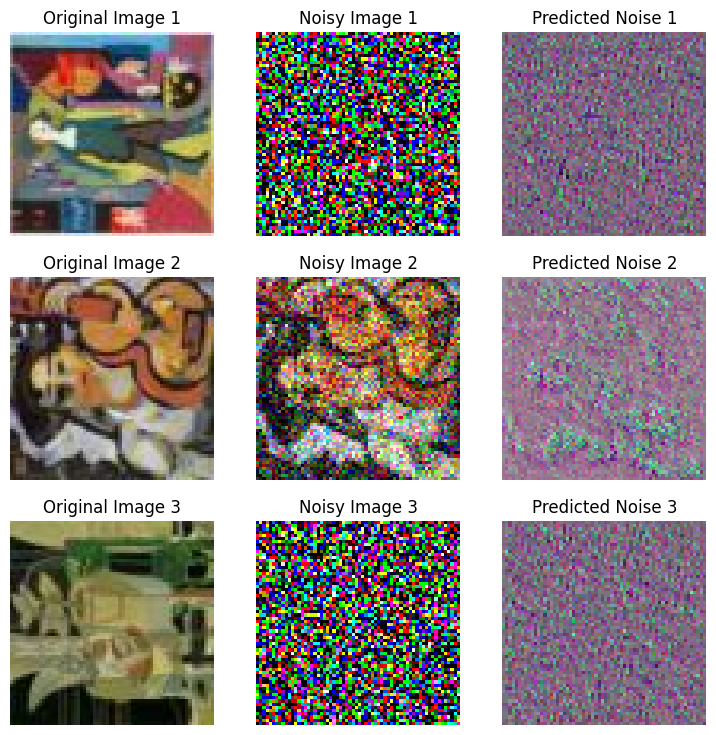

In [21]:
# lets investigate some of the noise and predicted noise
key = jax.random.PRNGKey(42)
fig, axs = plt.subplots(3, 3, figsize=(9, 9))
for i in range(3):
    axs[i, 0].imshow(jnp.swapaxes(batches[0, i], 0, 2))
    axs[i, 0].set_title(f"Original Image {i+1}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(jnp.swapaxes(batch_noisy[i], 0, 2))
    axs[i, 1].set_title(f"Noisy Image {i+1}")
    axs[i, 1].axis('off')

    pred_eps = denoiser(batch_ts[i], batch_noisy[i], key=key)
    axs[i, 2].imshow(jnp.swapaxes((pred_eps - jnp.min(pred_eps)) / (jnp.max(pred_eps) - jnp.min(pred_eps)), 0, 2))
    axs[i, 2].set_title(f"Predicted Noise {i+1}")
    axs[i, 2].axis('off')

# Inference

In [ ]:
@eqx.filter_jit
def generate_image(
    model : eqx.Module,
    alphas : jnp.ndarray = alphas,
    alphas_cumprod : jnp.ndarray = alphas_cumprod,
    betas : jnp.ndarray = betas,
    T : int = T,
    img_size : int = IMAGE_SIZE,
    key : jax.random.PRNGKey = jax.random.PRNGKey(42)
):
    """Generate an image by reversing the diffusion process."""
    key, subkey = jax.random.split(key)
    x = jax.random.normal(subkey, (1, 3, img_size, img_size))

    def body_fn(t, val):
        x, key = val
        key, subkey = jax.random.split(key)

        t_array = jnp.array([t])
        pred_eps = model(t_array, x[0], key=key)

        alpha_t = alphas[t - 1]
        alpha_cumprod_t = alphas_cumprod[t - 1]
        beta_t = betas[t - 1]

        coef = beta_t / jnp.sqrt(1 - alpha_cumprod_t)
        x = (1 / jnp.sqrt(alpha_t)) * (x - coef * pred_eps)

        sigma_t = jnp.sqrt(beta_t)
        key, subkey = jax.random.split(key)
        z = jax.random.normal(subkey, x.shape)
        x += sigma_t * z * (t > 1)

        return x, key
    
    x, _ = jax.lax.fori_loop(1, T + 1, body_fn, (x, key))

    x = jnp.clip(x, 0.0, 1.0)
    return x[0]

Sampling timestep JitTracer<~int32[]>


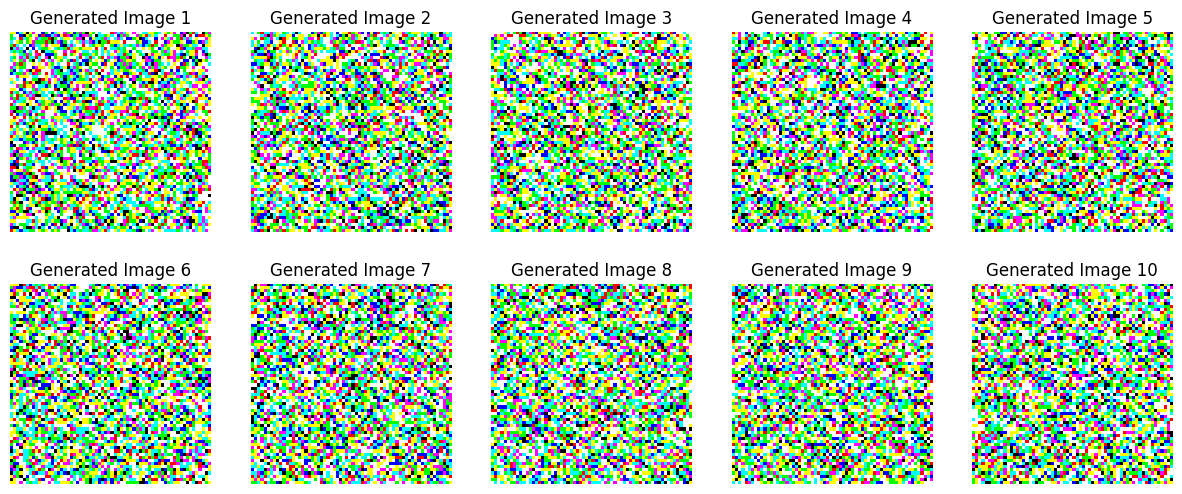

In [27]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    key, subkey = jax.random.split(key)
    generated_img = generate_image(denoiser, key=subkey)
    axs[i // 5, i % 5].imshow(jnp.swapaxes(generated_img, 0, 2))
    axs[i // 5, i % 5].axis('off')
    axs[i // 5, i % 5].set_title(f"Generated Image {i+1}")
plt.show()